<h1>Predictive Analysis Based on Customer Purchasing Behavior</h1>

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from lifetimes.utils import *
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from lifetimes.datasets import load_cdnow_summary_data_with_monetary_value
from lifetimes.plotting import plot_probability_alive_matrix, plot_frequency_recency_matrix
from lifetimes.generate_data import beta_geometric_nbd_model
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases, plot_period_transactions,plot_history_alive

In [2]:
#change source file path
df = pd.read_csv('C:/Users/toshiba/Desktop/AT&R/FP_src_pred.csv')
df.dtypes

Order Date              object
Full Name (Billing)     object
Phone (Billing)         object
Item Cost              float64
Quantity               float64
dtype: object

In [3]:
df['Customer ID'] = df['Phone (Billing)'].str[-7:]                 #this picks last 7 digits as ID
df['Customer ID'] = 'FP' + df['Customer ID'].astype(str)           #this adds company prefix to the ID, 'FP' in this case

In [4]:
df = df[['Customer ID', 'Full Name (Billing)', 'Order Date','Quantity','Item Cost']]

#if Order date is not of date type, then change its data type
df['Order Date'] = df['Order Date'].astype('datetime64[ns]')

In [5]:
#calculate total purchase amount
df['Total Purchase'] = df['Quantity'] * df['Item Cost']

In [6]:
cols_of_interest = ['Customer ID', 'Full Name (Billing)', 'Order Date', 'Total Purchase']
df = df[cols_of_interest]

In [7]:
#extract data summary
data = summary_data_from_transaction_data(df, 'Customer ID', 'Order Date', monetary_value_col='Total Purchase', observation_period_end='2019-08-21')

In [8]:
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 5743 subjects, a: 1.58, alpha: 56.25, b: 2.22, r: 0.12>


In [9]:
#calculated predicted purchases over a year
t = 365
data['Predicted Purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])

In [10]:
#calculated probability of being alive
data['Probability of Being Alive'] = bgf.conditional_probability_alive(data['frequency'],
                                  data['recency'],
                                  data['T'])


In [11]:
#calculate predicted average profit 
data2 = data[data['monetary_value'] > 1]
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(data2['frequency'], data2['monetary_value'])
AVGprofit = ggf.conditional_expected_average_profit(data2['frequency'], data2['monetary_value'])
avg_profit = AVGprofit.to_frame()


In [12]:
#calculated customer lifetime value over a year
CLV = ggf.customer_lifetime_value(bgf, data['frequency'], data['recency'], data['T'], data['monetary_value'], time = 12 , discount_rate=0.01)
clv = CLV.to_frame()
#time is in months

In [13]:
finaldf = data.merge(avg_profit, on='Customer ID', how='outer').merge(clv, on = 'Customer ID', how = 'inner' )
finaldf.drop(columns = ['frequency', 'recency', 'T', 'monetary_value'], inplace = True)

In [14]:
#for clustering according to cltv

finaldf.fillna(0, inplace = True)
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=0)
clusters = kmeans.fit_predict(clv)
finaldf['clv segment'] = clusters

#for clustering according to all measures
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=0)
clusters = kmeans.fit_predict(finaldf)
finaldf['Cluster'] = clusters

In [15]:
#Assigning names to clusters according to cltv

for i,row in finaldf.iterrows():
    if finaldf.loc[i,'clv segment'] == 0:
        finaldf.loc[i,'clv segment'] = 'Low CLV'
    elif finaldf.loc[i,'clv segment'] == 1:
        finaldf.loc[i,'clv segment'] = 'Medium CLV'
    elif finaldf.loc[i,'clv segment'] == 2:
        finaldf.loc[i,'clv segment'] = 'High CLV'      

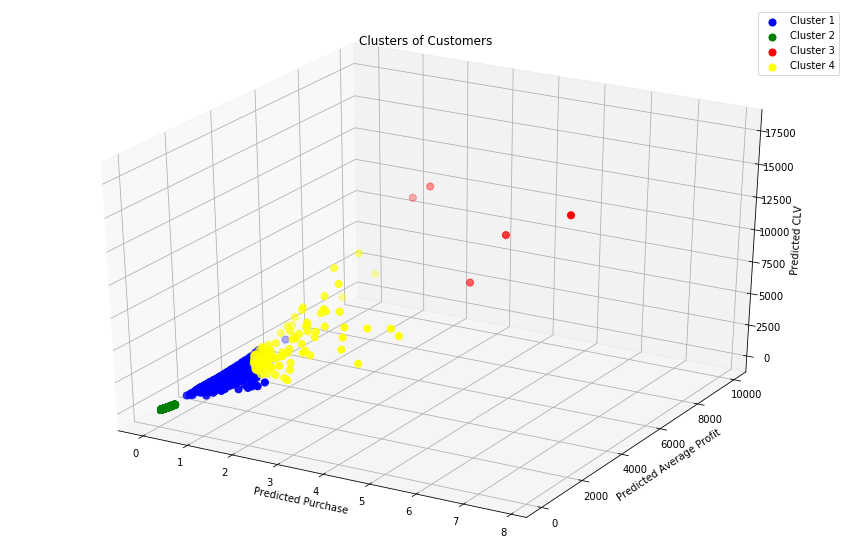

In [16]:
finaldf.columns = ['Predicted_Purchase', 'Pred_probability_of_Aliveness', 'Pred_Average_Profit', 'Pred_CLV', 'clv segmemt', 'Cluster']

#To visualize the clusters

fig = plt.figure(figsize=(15,10))
dx = fig.add_subplot(111, projection='3d')
colors = ['blue', 'green', 'red', 'yellow']

for i in range(0,4):
    dx.scatter(finaldf[finaldf.Cluster == i].Predicted_Purchase, 
               finaldf[finaldf.Cluster == i].Pred_Average_Profit, 
               finaldf[finaldf.Cluster == i].Pred_CLV, 
               c = colors[i], 
               label = 'Cluster ' + str(i+1), 
               s=50)

dx.set_title('Clusters of Customers')
dx.set_xlabel('Predicted Purchase')
dx.set_ylabel('Predicted Average Profit')
dx.set_zlabel('Predicted CLV')
dx.legend()

In [17]:
finaldf.to_csv('C:/Users/toshiba/Desktop/AT&R/FP_dest_pred.csv')